# Single file

In [ ]:
from classes_EIS import DataHandler, RRCRCModel,RRCRCCPEModel, FitManager

# Define initial guesses and bounds for each 
Rs_guess = 11.
R_guess = 1.5
fs_guess = 10**1.3
n_guess = 1.
R2_guess = 6e4
fs2_guess = 10**0.5
n2_guess = 1.

initial_guess_rrcrccpe = [Rs_guess, R_guess, fs_guess,n_guess, R2_guess, fs2_guess,n2_guess]
bounds_rrcrccpe = ([5, 1, 1e-2, 0.5, 1, 1e-2, 0.5], [15, 5, 1e7, 1.5, 1e6, 1e7, 1.5])

# R-RC-RC model with CPE
rrcrccpe_model = RRCRCCPEModel(initial_guess_rrcrccpe, bounds_rrcrccpe)


data_handler = DataHandler('MPR files/1_00V_10cyc.mpr')
fit_manager = FitManager(data_handler)

# Fit narrow range (high frequencies)
f_min=1e3; f_max = 1e6
fitted_rrcrccpe_model, rrcrccpe_covariance, rrcrccpe_fit_quality = fit_manager.fit_model(rrcrccpe_model, fmin=f_min, fmax=f_max)
print("R-RC-RC-CPE Parameters (narrow):", fitted_rrcrccpe_model.params)
print("R-squared:%.6f" %(rrcrccpe_fit_quality["R-squared"]))

# Fit whole range (except very slow freq.)
f_min = 4
fitted_rrcrccpe_model_2, rrcrccpe_covariance_2, rrcrccpe_fit_quality_2 = fit_manager.fit_model(rrcrccpe_model, fmin=f_min, fmax=f_max)
print("R-RC-RC-CPE Parameters:", fitted_rrcrccpe_model_2.params)
print("R-squared:%.6f" %(rrcrccpe_fit_quality_2["R-squared"]))

Using default initial guess: [11.0, 1.5, 19.952623149688797, 1.0, 60000.0, 3.1622776601683795, 1.0]
Parameters hitting bounds: [5.00000000e+00 1.69638330e+03 1.29051596e+00 8.26627505e+04]
R-RC-RC-CPE Parameters (narrow): [1.07203082e+01 5.00000000e+00 1.69638330e+03 1.00573764e+00
 1.29051596e+00 8.26627505e+04 8.45955143e-01]
R-squared:0.999986
Using previous fitted parameters as initial guess: [1.07203082e+01 5.00000000e+00 1.69638330e+03 1.00573764e+00
 1.29051596e+00 8.26627505e+04 8.45955143e-01]
Parameters hitting bounds: [5.00000000e+00 4.35443879e+01 1.50000000e+00 8.33899028e+00
 6.37827913e+04 5.00000000e-01]
R-RC-RC-CPE Parameters: [6.61626595e+00 5.00000000e+00 4.35443879e+01 1.50000000e+00
 8.33899028e+00 6.37827913e+04 5.00000000e-01]
R-squared:0.146525


# Multiple files

In [1]:
from classes_EIS import DataHandler, RRCRCModel,RRCRCCPEModel, FitManager,FitQuality, find_files
import matplotlib.pyplot as plt
import numpy as np


root_folder = "100 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=False)

# Define initial guesses and bounds for each 
Rs_guess = 11.
R_guess = 1.5
fs_guess = 10**1.3
n_guess = 1.
R2_guess = 6e4
fs2_guess = 10**0.5
n2_guess = 1.

initial_guess = [Rs_guess, R_guess, fs_guess,n_guess, R2_guess, fs2_guess,n2_guess]
bounds = (
    [5, 1., 10**1, 0.7, 1, 10**-1, 0.7],  # Lower bounds  (PREVIOUSLY 0.9)
    [15, 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

# R-RC-RC model with CPE
rrcrccpe_model = RRCRCCPEModel(initial_guess, bounds)

f_min = 4; f_max = 1e6
all_fitted_params = []
all_Ewe = []
all_fit_quality = []
for data_handler in [DataHandler(mpr_file) for mpr_file in mpr_files]:
    Ewe = data_handler.Ewe
    fit_manager = FitManager(data_handler)
    model, covariance, fit_quality = fit_manager.fit_model(rrcrccpe_model, fmin=f_min, fmax=f_max)

    all_fitted_params.append(model.params)
    all_Ewe.append(Ewe)
    all_fit_quality.append(fit_quality)

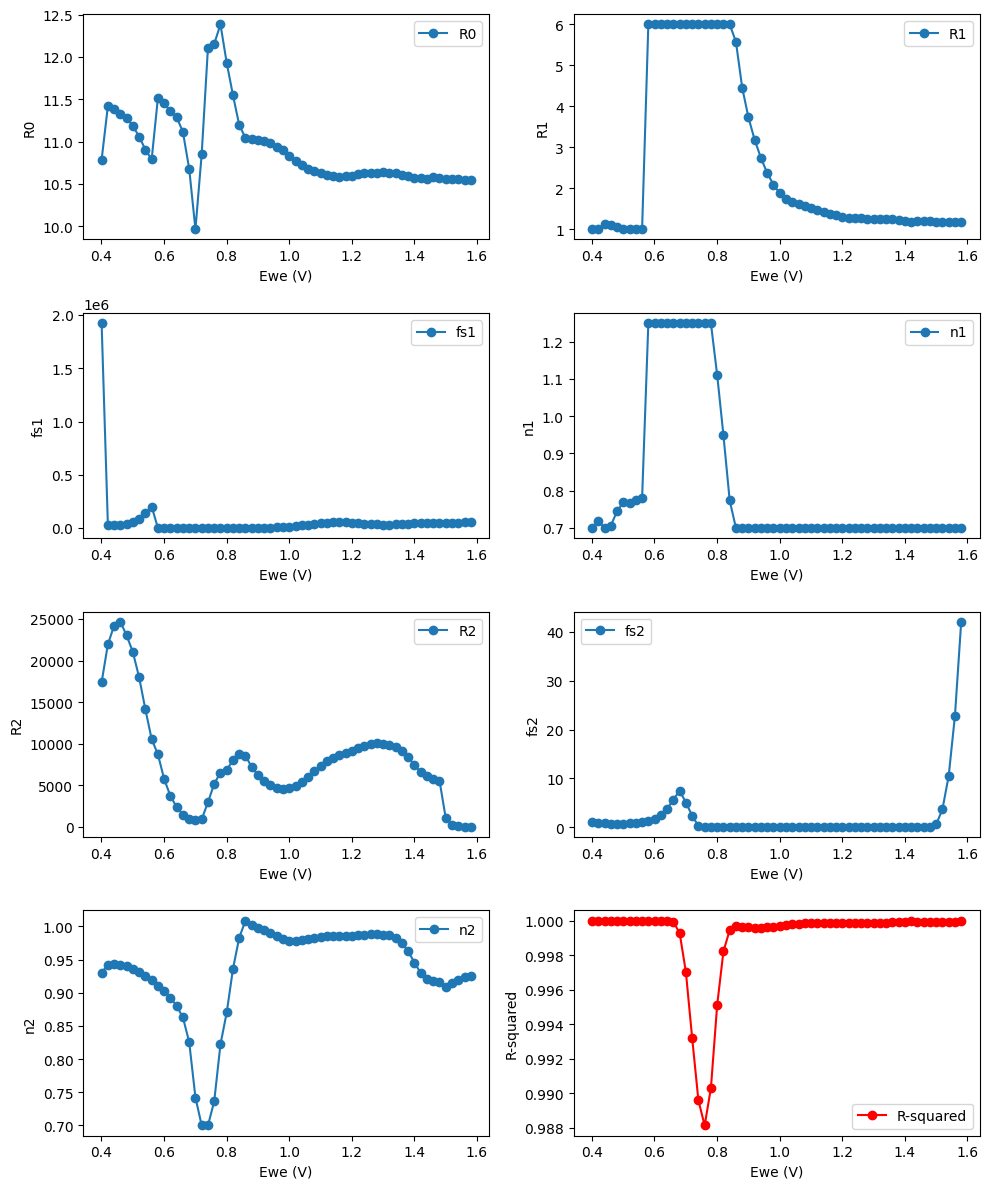

In [3]:
all_fitted_params = np.array(all_fitted_params)
all_Ewe = np.array(all_Ewe)
all_fit_quality = np.array(all_fit_quality)

# Determine the number of subplots: one for each parameter + one for fit quality
param_names = model.param_names  # Use the parameter names from the model class
num_params = all_fitted_params.shape[1]
total_plots = num_params + 1  # Parameters + fit quality plot

# Dynamically arrange the subplots based on the number of parameters
n_cols = 2 if total_plots > 3 else 1  # 2 columns if there are more than 3 plots
n_rows = (total_plots + n_cols - 1) // n_cols  # Calculate required rows

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))

# Flatten axs for easier indexing, even if it's a 2D array
axs = axs.flatten() if total_plots > 1 else [axs]

# Plot the parameters against Ewe, using the names from the model class
for i in range(num_params):
    axs[i].plot(all_Ewe, all_fitted_params[:, i], 'o-', label=param_names[i])
    axs[i].set_xlabel('Ewe (V)')
    axs[i].set_ylabel(param_names[i])
    axs[i].legend()

# Plot the fit quality (e.g., R-squared) on the last subplot
axs[num_params].plot(all_Ewe, all_fit_quality, 'o-', color='red', label='R-squared')
axs[num_params].set_xlabel('Ewe (V)')
axs[num_params].set_ylabel('R-squared')
axs[num_params].legend()

# Ensure the layout is tidy and plots are not overlapping
plt.tight_layout()
plt.show()

# Multiple files with varying f_min

In [56]:
from classes_EIS import DataHandler, RRCRCModel,RRCRCCPEModel, FitManager,FitQuality, find_files

import numpy as np

root_folder = "100 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=False)

# Define initial guesses and bounds for each 
Rs_guess = 11.
R_guess = 1.5
fs_guess = 10**1.3
n_guess = 1.
R2_guess = 6e4
fs2_guess = 10**0.5
n2_guess = 1.

initial_guess = [Rs_guess, R_guess, fs_guess,n_guess, R2_guess, fs2_guess,n2_guess]
bounds = (
    [5, 1., 10**1, 0.7, 1, 10**-1, 0.7],  # Lower bounds  (PREVIOUSLY 0.9)
    [15, 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

# R-RC-RC model with CPE
rrcrccpe_model = RRCRCCPEModel(initial_guess, bounds)
param_names = rrcrccpe_model.param_names

f_min = 4; f_max = 1e6#1e6

fmin_values = np.logspace(np.log10(4), np.log10(1000), 10)  # 10 values in log scale

fit_results = {fmin: {'Ewe': [], **{name: [] for name in param_names}, 'Residual': []} for fmin in fmin_values}

for data_handler in [DataHandler(mpr_file) for mpr_file in mpr_files]:
    Ewe = data_handler.Ewe
    
    fit_manager = FitManager(data_handler)

    for idx, fmin in enumerate(fmin_values):
        model, covariance, fit_quality = fit_manager.fit_model(rrcrccpe_model, fmin=fmin, fmax=f_max)

        for param_name in model.param_names:
            fit_results[fmin][param_name].append(model.params[model.param_names.index(param_name)])

        fit_results[fmin]['Residual'].append(fit_quality)
        fit_results[fmin]['Ewe'].append(Ewe)

        

/tmp/ipykernel_11566/2080576354.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit everything without overlap


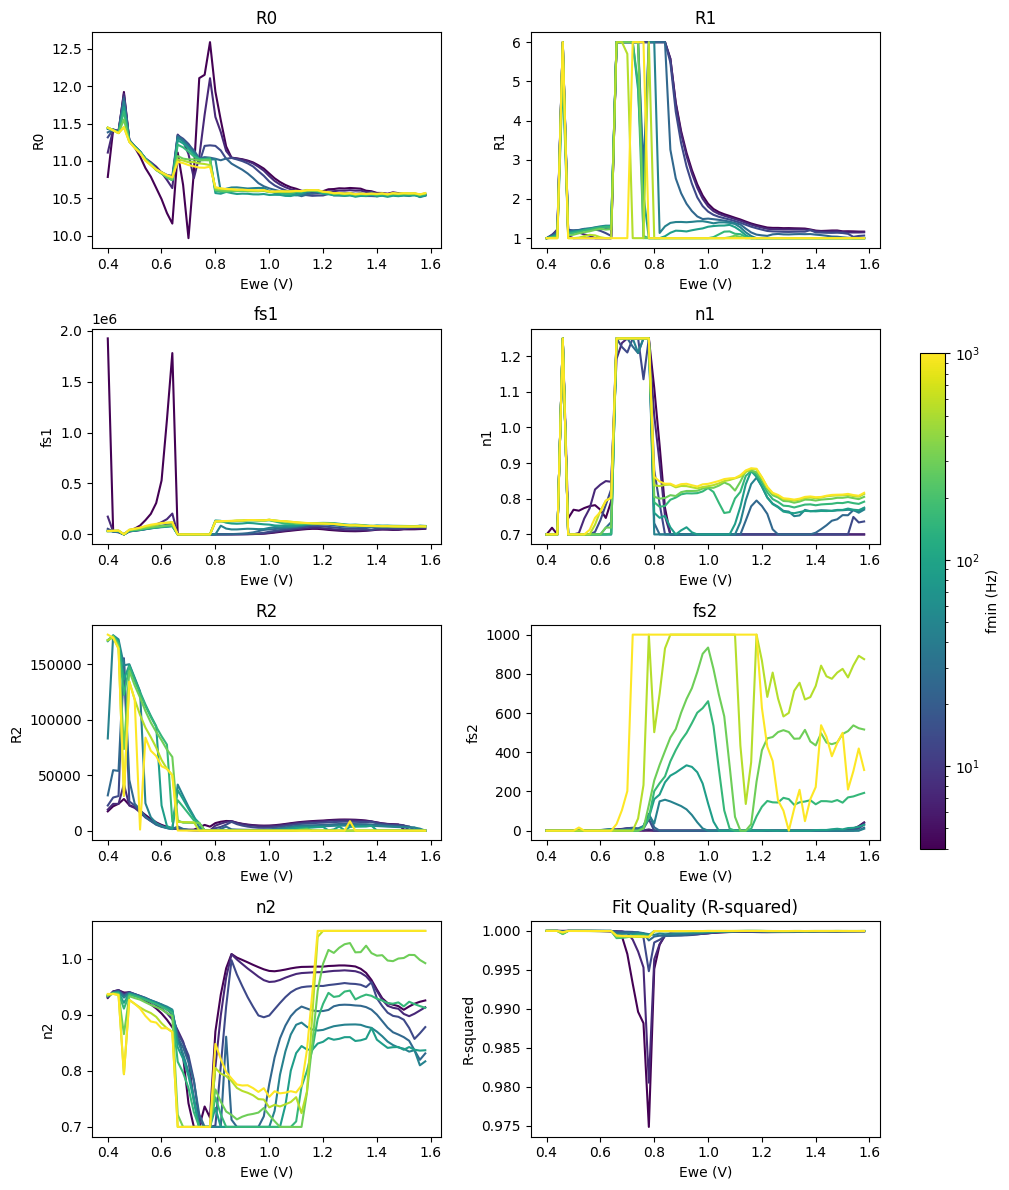

In [55]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

norm = LogNorm(vmin=min(fmin_values), vmax=max(fmin_values))
colors = cm.viridis(norm(fmin_values))
# After the fitting process...

# Plotting
num_params = len(model.param_names)
n_cols = 2 if num_params + 1 > 3 else 1  # 2 columns if more than 3 parameters + 1 for Residual
n_rows = (num_params + 1 + n_cols - 1) // n_cols  # Calculate required rows (+1 for Residual plot)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axs = axs.flatten()  # Flatten the array of subplots for easier indexing

# Now loop through the dictionary to plot each fmin for each parameter
for i, param_name in enumerate(model.param_names):
    for fmin in fmin_values:
        param_values = fit_results[fmin][param_name]
        Ewe_values = fit_results[fmin]['Ewe']

        # Check if there are values to plot and if they are the same length
        if len(Ewe_values) == len(param_values) > 0:
            axs[i].plot(Ewe_values, param_values, '-', color=cm.viridis(norm(fmin)), label=f'fmin={fmin:.0f}')
        else:
            print(f"No data to plot for {param_name} at fmin={fmin}.")
            print(f"Ewe length: {len(Ewe_values)}, {param_name} length: {len(param_values)}")

    axs[i].set_xlabel('Ewe (V)')
    axs[i].set_ylabel(param_name)
    axs[i].set_title(param_name)
    axs[i].grid(True, linestyle='--', alpha=0.7)

# Plot the fit quality (Residual) in the last subplot
for fmin in fmin_values:
    residual_values = fit_results[fmin]['Residual']
    Ewe_values = fit_results[fmin]['Ewe']
    
    # Check if there are values to plot
    if len(Ewe_values) == len(residual_values) > 0:
        axs[-1].plot(Ewe_values, residual_values, '-', color=cm.viridis(norm(fmin)))
    else:
        print(f"No residual data to plot for fmin={fmin}.")
        print(f"Ewe length: {len(Ewe_values)}, Residual length: {len(residual_values)}")

axs[-1].set_xlabel('Ewe (V)')
axs[-1].set_ylabel('R-squared')
axs[-1].set_title('Fit Quality (R-squared)')
axs[-1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(right=0.95, hspace=0.4)  # Adjust right side and space between rows

# Add a colorbar to represent the fmin values (logarithmic scale)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)  # Position the colorbar
cbar.set_label('fmin (Hz)')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit everything without overlap
plt.show()


# Multiple files with varying f_max

In [52]:
from classes_EIS import DataHandler, RRCRCModel,RRCRCCPEModel, FitManager,FitQuality, find_files

import numpy as np

root_folder = "100 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=False)

# Define initial guesses and bounds for each 
Rs_guess = 11.
R_guess = 1.5
fs_guess = 10**1.3
n_guess = 1.
R2_guess = 6e4
fs2_guess = 10**0.5
n2_guess = 1.

initial_guess = [Rs_guess, R_guess, fs_guess,n_guess, R2_guess, fs2_guess,n2_guess]
bounds = (
    [5, 1., 10**1, 0.7, 1, 10**-1, 0.7],  # Lower bounds  (PREVIOUSLY 0.9)
    [15, 6., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds
    )

# R-RC-RC model with CPE
rrcrccpe_model = RRCRCCPEModel(initial_guess, bounds)
param_names = rrcrccpe_model.param_names

f_min = 4; f_max = 1e6

fmax_values = np.logspace(np.log10(1e3), np.log10(1e6), 10)  # 10 values in log scale

fit_results = {fmax: {'Ewe': [], **{name: [] for name in param_names}, 'Residual': []} for fmax in fmax_values}

for data_handler in [DataHandler(mpr_file) for mpr_file in mpr_files]:
    Ewe = data_handler.Ewe
    
    fit_manager = FitManager(data_handler)

    for idx, fmax in enumerate(fmax_values):
        model, covariance, fit_quality = fit_manager.fit_model(rrcrccpe_model, fmin=f_min, fmax=fmax)

        for param_name in model.param_names:
            fit_results[fmax][param_name].append(model.params[model.param_names.index(param_name)])

        fit_results[fmax]['Residual'].append(fit_quality)
        fit_results[fmax]['Ewe'].append(Ewe)

/tmp/ipykernel_11566/1546489460.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit everything without overlap


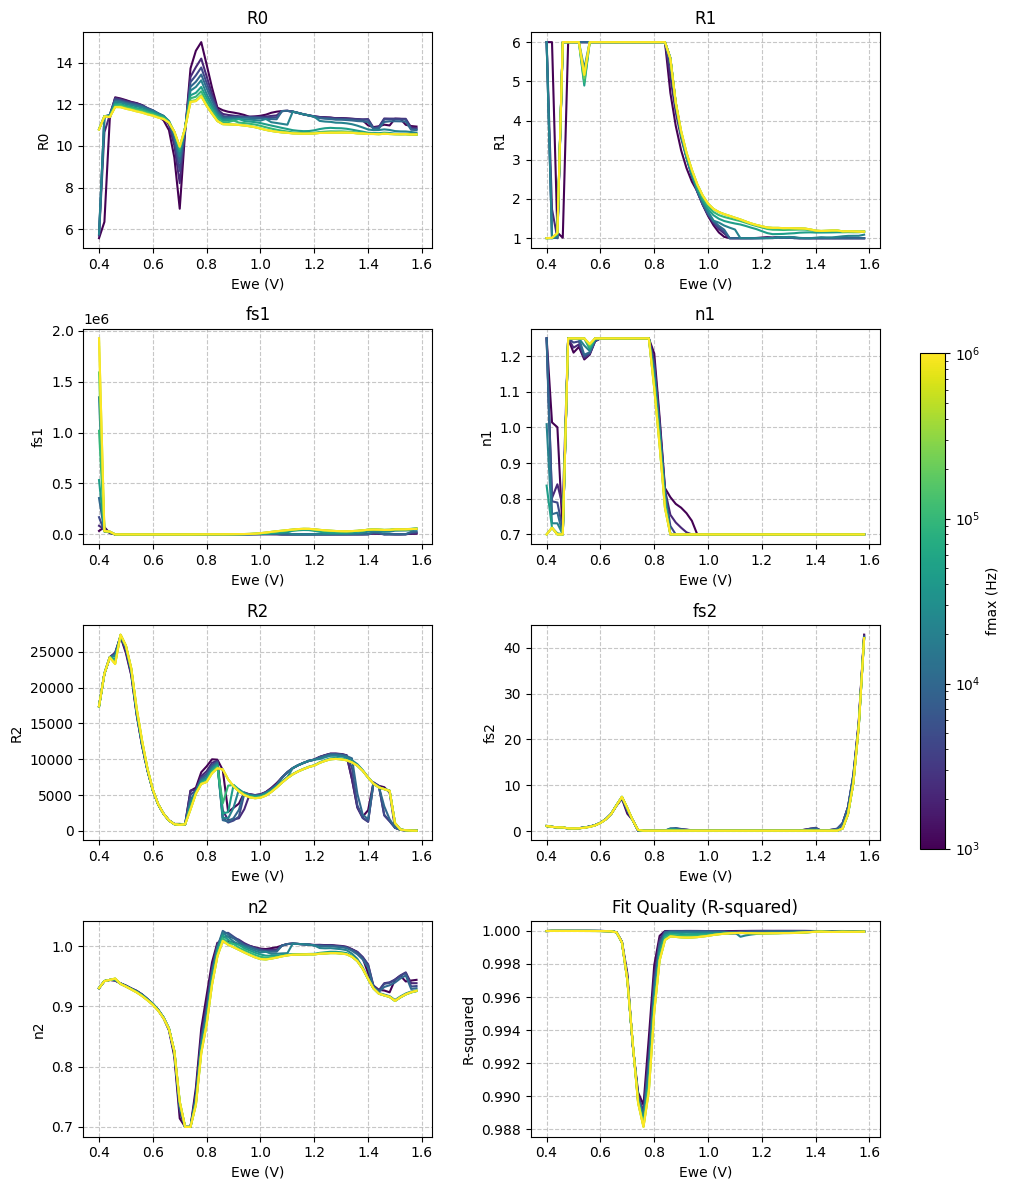

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

norm = LogNorm(vmin=min(fmax_values), vmax=max(fmax_values))
colors = cm.viridis(norm(fmax_values))
# After the fitting process...

# Plotting
num_params = len(model.param_names)
n_cols = 2 if num_params + 1 > 3 else 1  # 2 columns if more than 3 parameters + 1 for Residual
n_rows = (num_params + 1 + n_cols - 1) // n_cols  # Calculate required rows (+1 for Residual plot)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
axs = axs.flatten()  # Flatten the array of subplots for easier indexing

# Now loop through the dictionary to plot each fmax for each parameter
for i, param_name in enumerate(model.param_names):
    for fmax in fmax_values:
        param_values = fit_results[fmax][param_name]
        Ewe_values = fit_results[fmax]['Ewe']

        # Check if there are values to plot and if they are the same length
        if len(Ewe_values) == len(param_values) > 0:
            axs[i].plot(Ewe_values, param_values, '-', color=cm.viridis(norm(fmax)), label=f'fmax={fmax:.0f}')
        else:
            print(f"No data to plot for {param_name} at fmax={fmax}.")
            print(f"Ewe length: {len(Ewe_values)}, {param_name} length: {len(param_values)}")

    axs[i].set_xlabel('Ewe (V)')
    axs[i].set_ylabel(param_name)
    axs[i].set_title(param_name)
    axs[i].grid(True, linestyle='--', alpha=0.7)

# Plot the fit quality (Residual) in the last subplot
for fmax in fmax_values:
    residual_values = fit_results[fmax]['Residual']
    Ewe_values = fit_results[fmax]['Ewe']
    
    # Check if there are values to plot
    if len(Ewe_values) == len(residual_values) > 0:
        axs[-1].plot(Ewe_values, residual_values, '-', color=cm.viridis(norm(fmax)))
    else:
        print(f"No residual data to plot for fmax={fmax}.")
        print(f"Ewe length: {len(Ewe_values)}, Residual length: {len(residual_values)}")

axs[-1].set_xlabel('Ewe (V)')
axs[-1].set_ylabel('R-squared')
axs[-1].set_title('Fit Quality (R-squared)')
axs[-1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(right=0.95, hspace=0.4)  # Adjust right side and space between rows

# Add a colorbar to represent the fmax values (logarithmic scale)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for the colorbar
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)  # Position the colorbar
cbar.set_label('fmax (Hz)')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit everything without overlap
plt.show()
